## LENET5 
Basico modelo de rede neural convolucional.

Baixar os dados de treinamento da rede. Iremos usar o CIFAR-10 dataset, que é um dataset de imagens de 32x32 pixels divididas em 10 classes.

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image

import PIL 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from datetime import date

# Codigos auxiliares


In [ ]:
def plotar_convolucoes(linhas, colunas, tensor, pixels, dim=(5,5)):
  fig, ax = plt.subplots(linhas, colunas, figsize=dim)
  for linha in range(linhas):
    for coluna in range(colunas):
      i = (linha * linhas) + coluna
      tmp = tensor[0,i,:,:].view(1,pixels,pixels).detach()
      tmp = to_pil_image(tmp)#.resize((200,200))
      ax[linha, coluna].imshow(np.asarray(tmp))
      ax[linha, coluna].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

  plt.tight_layout()

# Dados

In [ ]:
converte_tensor = transforms.Compose([transforms.ToTensor()])

In [ ]:
diretorio = "."

treino = datasets.CIFAR10(diretorio, train=True, download=True, transform = converte_tensor)

teste = datasets.CIFAR10(diretorio, train=False, download=True, transform = converte_tensor)

# DataLoader

In [ ]:
lote = 64

treino_loader = torch.utils.data.DataLoader(treino, batch_size = lote)

teste_loader = torch.utils.data.DataLoader(teste, batch_size = lote)

In [ ]:
import os
path = os.getcwd()
DIRETORIO_PADRAO = path + "/modelos/"


## Loop de treinamento

In [ ]:
from tqdm import tqdm

def treinar(treino_ldr, teste_ldr, modelo, **kwargs):

  DISPOSITIVO_EXECUCAO = 'cuda' if torch.cuda.is_available() else 'cpu'

  modelo.to(DISPOSITIVO_EXECUCAO)

  tx_aprendizado = kwargs.get('tx_aprendizado', 0.0001)
  otimizador = kwargs.get('opt', optim.Adadelta(modelo.parameters(), lr=tx_aprendizado, weight_decay=0.0005))
  custo = kwargs.get('custo', F.nll_loss)
  epocas = kwargs.get('epocas', 10)
  nao_imprimir = kwargs.get('nao_imprimir', True)

  arquivo_checkpoint = kwargs.get('arquivo_checkpoint', DIRETORIO_PADRAO + 'modelo.pt')

  curva_treino = []
  curva_teste = []

  acc_treino = [0]
  acc_teste = [0]

  barra_progresso = tqdm(range(epocas))

  for epoca in barra_progresso:

    posfixo_barra = 'Acurácia Treino: {} Teste: {}'.format(round(acc_treino[-1], 2), round(acc_teste[-1]),2)

    if epoca % 5 == 0:
      torch.save(modelo.state_dict(), arquivo_checkpoint)
      posfixo_barra = posfixo_barra + ' Checkpoint!'

    barra_progresso.set_postfix_str(posfixo_barra)


    ##################
    # TREINO
    ##################

    modelo.train()              # Habilita o treinamento do modelo

    acc = []
    erros = []
    for imagem, classe in treino_ldr:

      imagem = imagem.to(DISPOSITIVO_EXECUCAO)
      classe = classe.to(DISPOSITIVO_EXECUCAO)

      otimizador.zero_grad()
      predicao = modelo.forward(imagem)
      erro = custo(predicao, classe)
      erro.backward()
      otimizador.step()

      # Grava as métricas de avaliação
      erros.append(erro.cpu().item())
      preds = torch.argmax(predicao, dim=1).cpu().numpy()      # Transforma a codificação One-Hot-Encode em um número de classe
      classes = classe.cpu().tolist()
      acc.append(accuracy_score(classes, preds))

    # Salva o valor médio das métricas de avaliação para o lote
    acc_treino.append(np.mean(acc))
    curva_treino.append(np.mean(erros))


    ##################
    # VALIDAÇÃO
    ##################

    modelo.eval()               # Desabilita a atualização dos parâmetros

    acc = []
    erros = []
    with torch.no_grad():
      for imagem, classe in teste_ldr:
        imagem = imagem.to(DISPOSITIVO_EXECUCAO)
        classe = classe.to(DISPOSITIVO_EXECUCAO)
        predicao_val = modelo.forward(imagem)
        erro_val = custo(predicao_val, classe)

        # Grava as métricas de avaliação
        erros.append(erro_val.cpu().item())
        preds = torch.argmax(predicao_val, dim=1).cpu().numpy()      # Transforma a codificação One-Hot-Encode em um número de classe
        classes = classe.cpu().tolist()
        acc.append(accuracy_score(classes, preds))

      # Salva o valor médio das métricas de avaliação para o lote
      acc_teste.append(np.mean(acc))
      curva_teste.append(np.mean(erros))


  torch.save(modelo.state_dict(), arquivo_checkpoint)

  return curva_treino, curva_teste, acc_treino, acc_teste


Criando o modelo LENET5

In [62]:
arquivo = DIRETORIO_PADRAO + 'lenet-modular{}.pt'.format(date.today())

class Lenet5Modular(nn.Module):
  def __init__(self):
    super(Lenet5Modular,self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5),stride=(1,1)),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1)),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=120,kernel_size=(5,5),stride=(1,1)),
        nn.Tanh()
    )

    self.flat = nn.Flatten()

    self.linear1 = nn.Sequential(
        nn.Linear(120,84),
        nn.Tanh()
    )

    self.linear2 = nn.Linear(84,10)

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.flat(x)
    x = self.linear1(x)
    x = self.linear2(x)

    return x


modelo = Lenet5Modular()

# modelo.load_state_dict(torch.load(arquivo))

modelo.cpu()

a = torch.rand(1, 3, 32, 32)

b = modelo(a)

b.size()

torch.Size([1, 10])

## treinar modelo 

In [ ]:

# modelo.load_state_dict(torch.load(arquivo))

tr, val, atr, aval = treinar(treino_loader, teste_loader, modelo, epocas=200,
                                 opt = optim.SGD(modelo.parameters(), lr=0.01),
                                 custo=nn.CrossEntropyLoss(),
                                 arquivo_checkpoint=arquivo, nao_imprimir=True)


fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(tr, color='blue', label='Treino')
ax[0].plot(val, color='red', label='Validação')
ax[0].set_title("Loss")

ax[1].plot(atr, color='blue', label='Treino')
ax[1].plot(aval, color='red', label='Validação')
ax[1].set_title("Accuracy")

plt.legend()

# Visualizaçao do mapa de Características

In [52]:
modelo.load_state_dict(torch.load(arquivo))

<All keys matched successfully>

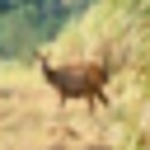

In [53]:
img, classe = teste[130]

to_pil_image(img).resize((150,150))

In [54]:
img = img.view(1,3,32,32)
cv1 = modelo.conv1(img)
cv1.size()

torch.Size([1, 6, 14, 14])

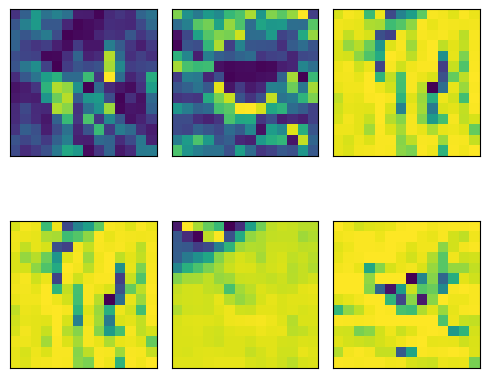

In [55]:
plotar_convolucoes(2, 3, cv1, 14)

In [56]:
cv2 = modelo.conv2(cv1)
cv2.size()

torch.Size([1, 16, 5, 5])

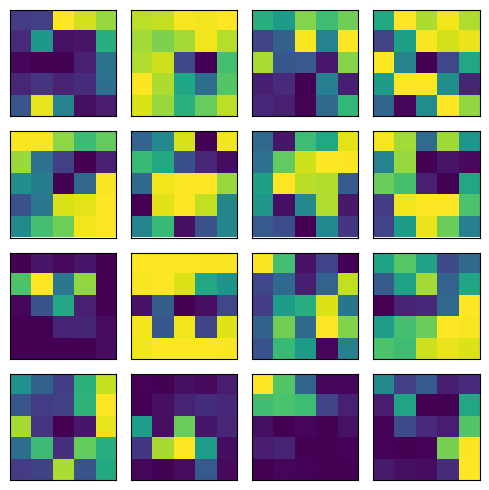

In [57]:
plotar_convolucoes(4, 4, cv2, 5)

In [58]:
# Predict da imagem
predicao = modelo(img)

# Nome da classe 
classe = torch.argmax(predicao).item()

In [59]:
# dicionario das classes 
classes = {0: 'Avião', 1: 'Carro', 2: 'Pássaro', 3: 'Gato', 4: 'Cervo', 5: 'Cachorro', 6: 'Sapo', 7: 'Cavalo', 8: 'Navio', 9: 'Caminhão'}

# Nome da classe
classes[classe]

'Cervo'

In [ ]:
predicao

In [64]:
import gradio as gr


model = Lenet5Modular()

model.load_state_dict(torch.load(arquivo))

c:\Users\hudso\AI\DL\lenet5\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [71]:
# Função para criar o transformador
def create_transformer():
    return transforms.Compose([
        transforms.Resize((32, 32)),  # Redimensionar para 32x32
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor()
    ])

In [75]:
# Função de classificação de imagem
def classifier_image(image):
    preprocess = create_transformer()

    # Converter a imagem para PIL se não estiver neste formato
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'), 'RGB')
    # Redimensionar a imagem para 32x32
    image = image.resize((32, 32))
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)

    # Realizar a predição
    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

    return f"{str(classes[predicted_class.item()])}"

# Interface Gradio
gr.Interface(fn=classifier_image, inputs="image", outputs="text").launch()

Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.
